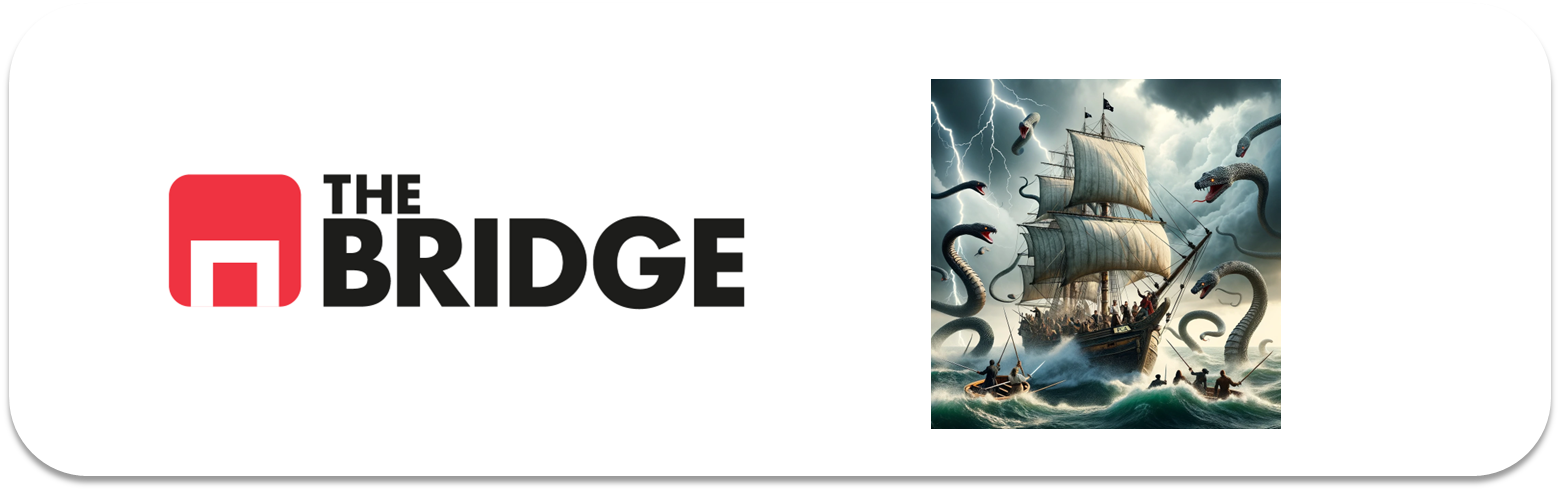

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [77]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.preprocessing import OrdinalEncoder


from collections import Counter

from sklearn.pipeline import Pipeline



### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [78]:
data = pd.read_csv("./data/credit_npo.csv")

In [79]:
data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [81]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,12537.0,0.068916,0.253321,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,12537.0,0.330359,0.368148,0.0,0.030651,0.163490,0.582219,6.0
age,12537.0,52.079445,15.077498,21.0,41.000000,51.000000,62.000000,101.0
NumberOfTime30-59DaysPastDueNotWorse,12537.0,0.409588,4.055787,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,12537.0,1.902253,9.122216,0.0,0.142268,0.302025,0.506725,99.0
MonthlyIncome,11816.0,6864.815420,11855.905437,0.0,3498.750000,5416.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,12537.0,8.482332,5.165422,0.0,5.000000,8.000000,11.000000,49.0
NumberOfTimes90DaysLate,12537.0,0.259312,4.035658,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,12537.0,0.999202,1.134325,0.0,0.000000,1.000000,2.000000,19.0
NumberOfTime60-89DaysPastDueNotWorse,12537.0,0.228364,4.018873,0.0,0.000000,0.000000,0.000000,98.0


In [82]:
#Elimino las filas con nulos:
data_clean = data.dropna().copy()

In [83]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [84]:
#Transformar variables NumberOf... a categóricas
# Binarizar si hubo impagos o no
data_clean["HadLate30_59"] = (data_clean["NumberOfTime30-59DaysPastDueNotWorse"] > 0).astype(int)
data_clean["HadLate60_89"] = (data_clean["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
data_clean["HadLate90"] = (data_clean["NumberOfTimes90DaysLate"] > 0).astype(int)

# Agrupar el número de préstamos en categorías: pocos, medios, muchos
data_clean["RealEstateLoansCat"] = pd.cut(
    data_clean["NumberRealEstateLoansOrLines"],
    bins=[-1, 0, 2, float('inf')],
    labels=["Ninguno", "Moderado", "Muchos"]
)


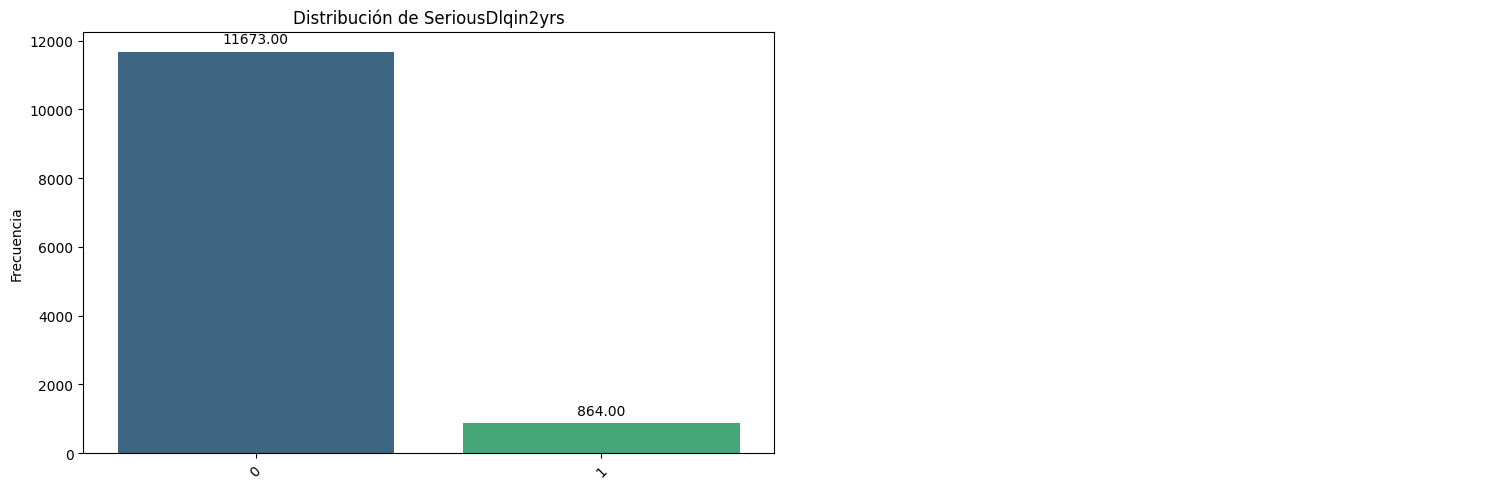

In [85]:
# Distribución del target

target = "SeriousDlqin2yrs"
bt.pinta_distribucion_categoricas(data,[target], mostrar_valores= True, relativa=False)

In [86]:
X = data_clean.drop(columns=["SeriousDlqin2yrs"])
y = data_clean["SeriousDlqin2yrs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [87]:
train_data = X_train.copy()
train_data["SeriousDlqin2yrs"]= y_train

(14, 2)


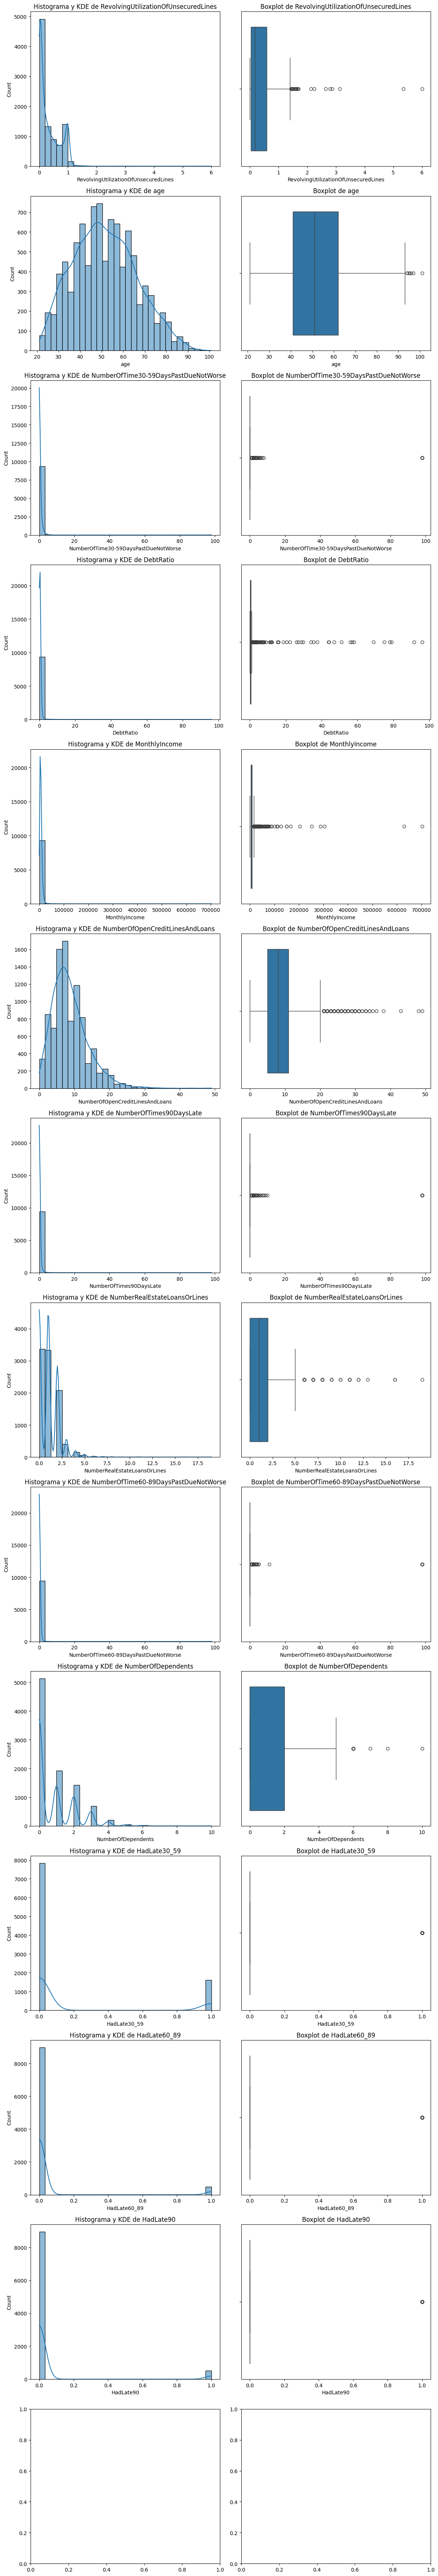

In [88]:
features_to_plot = train_data.drop(columns=["SeriousDlqin2yrs"]).columns.tolist()
bt.plot_combined_graphs(train_data, features_to_plot, bins = 30) 


RevolvingUtilizationOfUnsecuredLines: La mayoría de valores están por debajo de 1, es decir 100% del crédito disponible. La densidad cae mucho después de ahí pero hay valores que superan el 100% lo que indica que hay personas que usan más crédito del disponible. Riesgo financiero. El diagrama de caja confirma qeu casi todos se agrupan en el entorno de 0 y hay outliers por encima ede 1. Potencial variable para detectar perfiles de riesgo.  
Age: Distribución normal. Pocos outliers. Mantenerla así para el modelo.  
NumberOfTime30-59DaysPastDueNotWorse: La gran mayoría de valores son 0. Hay una pequeña cola y un valor extremo de 98. Deberíamos binarizarla y ver simplemente si una persona ha tenido al menos un impago.  
Sigo con las NumberOf...
NumberOfTimes90DaysLate: Mayoría en 0. Pequeña cola a la derecha y outliers larguísimos muy por encima del rango intercuartílico. El valor 98 parece fuera de escala y no aportá valor. La binarizo.  
NumberOfTime60-89DaysPastDueNotWorse: Claramente casi todo en ceros. Boxplot aplastado en el 0 y los bigotes se van con unos pocos valores a derecha. Binarizar.
DebtRatio: Concentración masiva de valores bajos cercanos a 0. Cola a la derecha. La densidad desaparece después de 2 o 3 pero hay casos extremos como vimos en el describe. Hay muchísimos outliers. Como no es discreta no puedo bonarizarla pero puedo aplicar un logaritmo a ver qué sale.  
MonthlyIncome: Mayoría de ingresos en valores bajos aunque también hay larga cola.   
NumberOfOpenCreditLinesAndLoans: Vamos a manejarla como continua.   
NumberRealEstateLoansOrLines: Se puede categorizar en 0, 1-2 y más de 2.  
NumberOfDependants: casi todos tienen 0 y 1 hay hasta con 10. Boxplot bien concentrado pero con algún outlier. Vamos a mantenerla como numérica discreta. Si trabajamos árboles puede valer así.




In [89]:
#Binarizo NumberOfTime30-59DaysPastDueNotWorse en train y en test

X_train["HadLate30_59"] = (X_train["NumberOfTime30-59DaysPastDueNotWorse"] > 0).astype(int)
X_test["HadLate30_59"] = (X_test["NumberOfTime30-59DaysPastDueNotWorse"] > 0).astype(int)

# Eliminar la original
X_train = X_train.drop(columns=["NumberOfTime30-59DaysPastDueNotWorse"])
X_test = X_test.drop(columns=["NumberOfTime30-59DaysPastDueNotWorse"])

# Actualizar train_data para exploración si la estás usando
train_data = X_train.copy()
train_data["SeriousDlqin2yrs"] = y_train

In [90]:
# Binarizar en train y test NumberOfTimes90DaysLate
X_train["HadLate90"] = (X_train["NumberOfTimes90DaysLate"] > 0).astype(int)
X_test["HadLate90"] = (X_test["NumberOfTimes90DaysLate"] > 0).astype(int)

# Eliminar la original
X_train = X_train.drop(columns=["NumberOfTimes90DaysLate"])
X_test = X_test.drop(columns=["NumberOfTimes90DaysLate"])

# Actualizar train_data para visualizaciones
train_data = X_train.copy()
train_data["SeriousDlqin2yrs"] = y_train

In [91]:
# Aplicar log(1 + x) para evitar problemas con ceros a DebtRatio
X_train["DebtRatio_log"] = np.log1p(X_train["DebtRatio"])
X_test["DebtRatio_log"] = np.log1p(X_test["DebtRatio"])

# Si prefieres eliminar la original, también:
X_train.drop(columns=["DebtRatio"], inplace=True)
X_test.drop(columns=["DebtRatio"], inplace=True)

# Actualizar también train_data si lo estás usando para visualización
train_data = X_train.copy()
train_data["SeriousDlqin2yrs"] = y_train


In [92]:
# Binarizar en train y test NumberOfTime60-89DaysPastDueNotWorse
X_train["HadLate60_89"] = (X_train["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
X_test["HadLate60_89"] = (X_test["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)

# Eliminar la variable original
X_train = X_train.drop(columns=["NumberOfTime60-89DaysPastDueNotWorse"])
X_test = X_test.drop(columns=["NumberOfTime60-89DaysPastDueNotWorse"])

# Actualizar el conjunto de entrenamiento combinado, si lo estás utilizando para EDA
train_data = X_train.copy()
train_data["SeriousDlqin2yrs"] = y_train

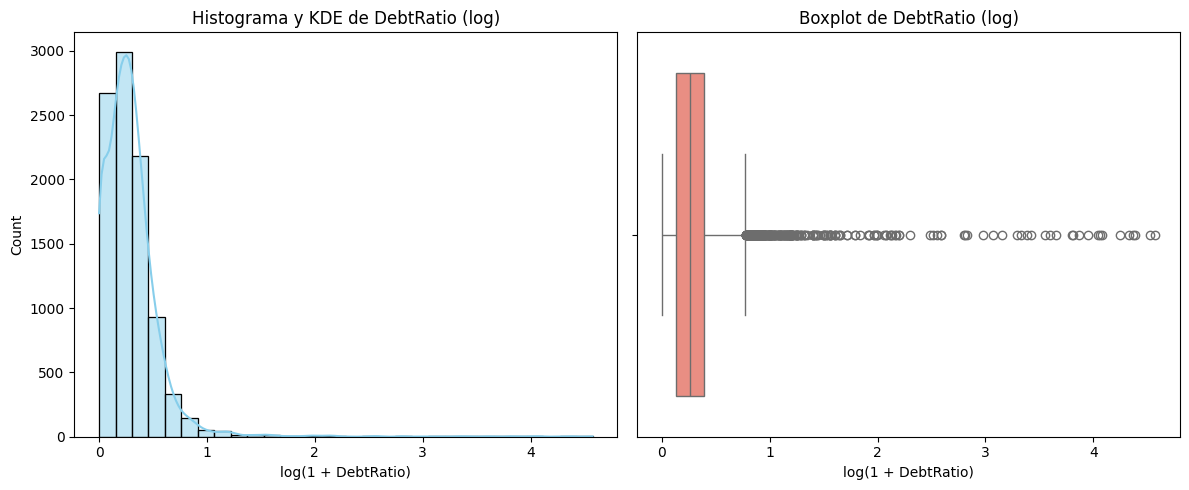

In [93]:
plt.figure(figsize=(12, 5))

# Histograma + KDE
plt.subplot(1, 2, 1)
sns.histplot(X_train["DebtRatio_log"], kde=True, bins=30, color="skyblue")
plt.title("Histograma y KDE de DebtRatio (log)")
plt.xlabel("log(1 + DebtRatio)")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=X_train["DebtRatio_log"], color="salmon")
plt.title("Boxplot de DebtRatio (log)")
plt.xlabel("log(1 + DebtRatio)")

plt.tight_layout()
plt.show()

In [94]:
# Aplicar transformación logarítmica a MonthlyIncome
X_train["MonthlyIncome_log"] = np.log1p(X_train["MonthlyIncome"])
X_test["MonthlyIncome_log"] = np.log1p(X_test["MonthlyIncome"])

In [95]:
# Categorización en ambos conjuntos RealEstateLoans
X_train["RealEstateLoansCat"] = pd.cut(
    X_train["NumberRealEstateLoansOrLines"],
    bins=[-1, 0, 2, float("inf")],
    labels=["Ninguno", "Moderado", "Muchos"]
)

X_test["RealEstateLoansCat"] = pd.cut(
    X_test["NumberRealEstateLoansOrLines"],
    bins=[-1, 0, 2, float("inf")],
    labels=["Ninguno", "Moderado", "Muchos"]
)

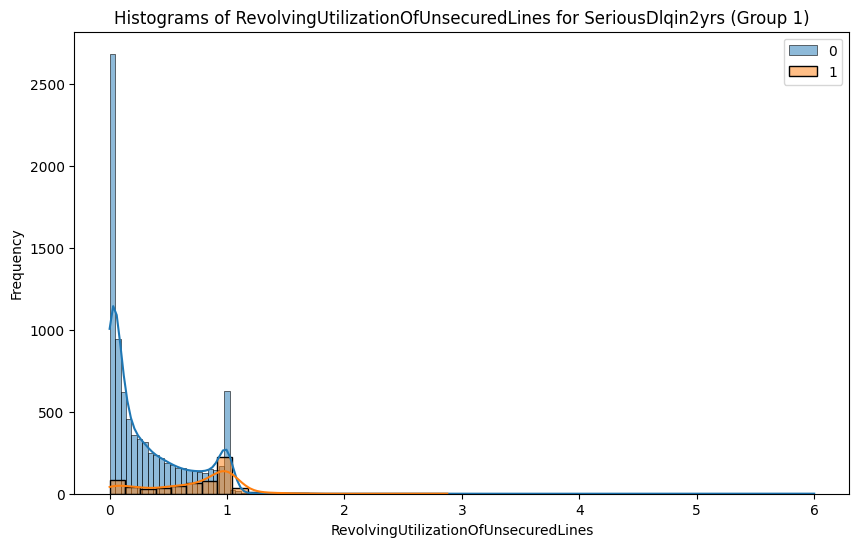

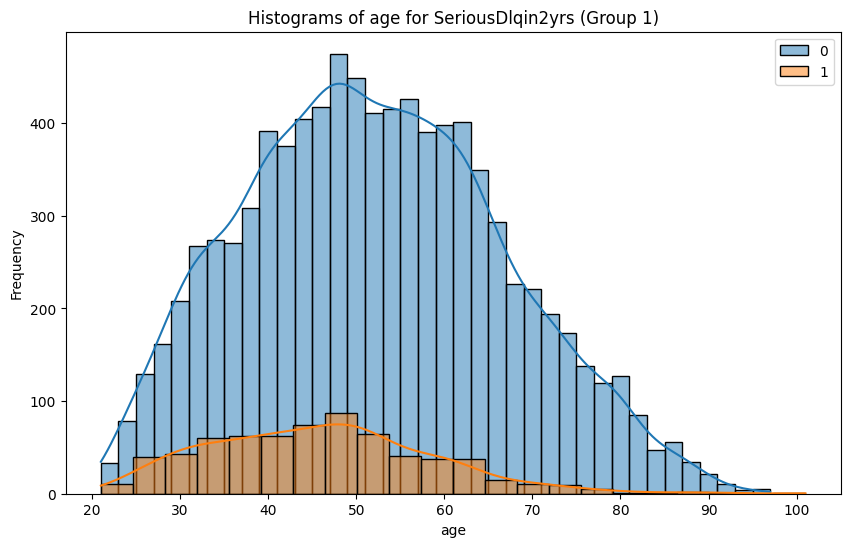

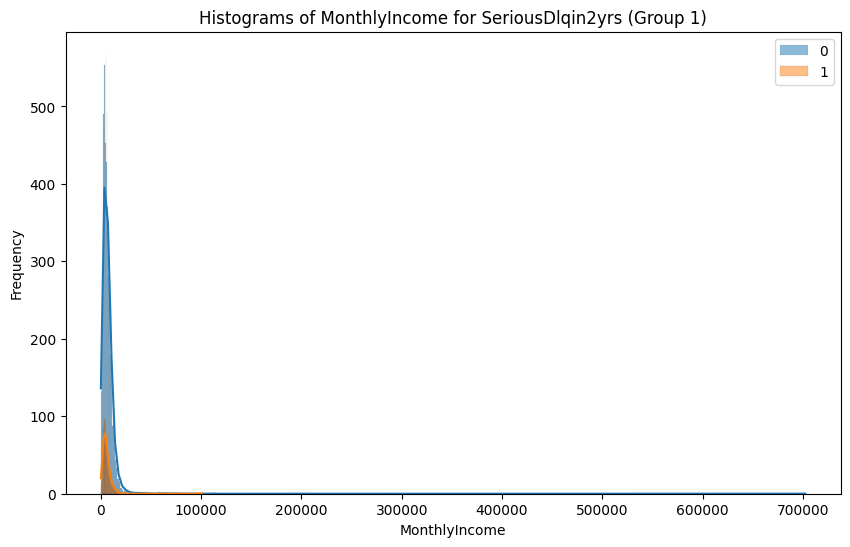

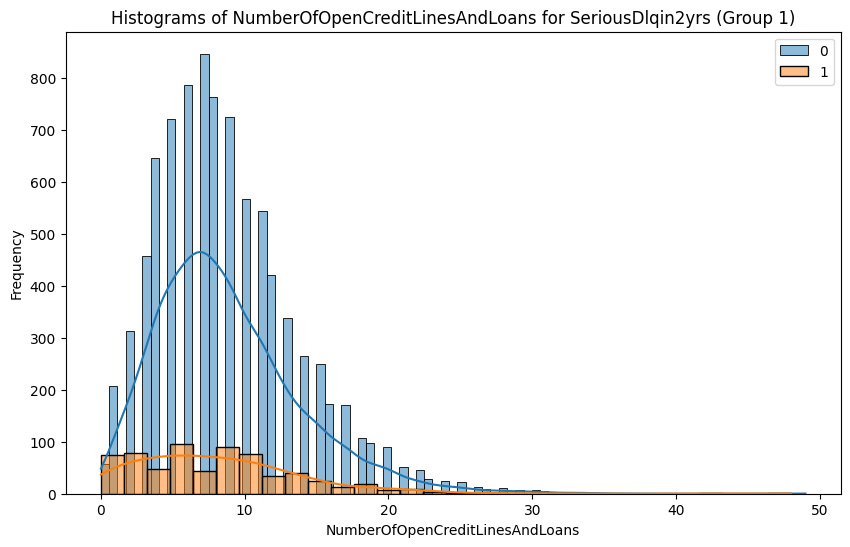

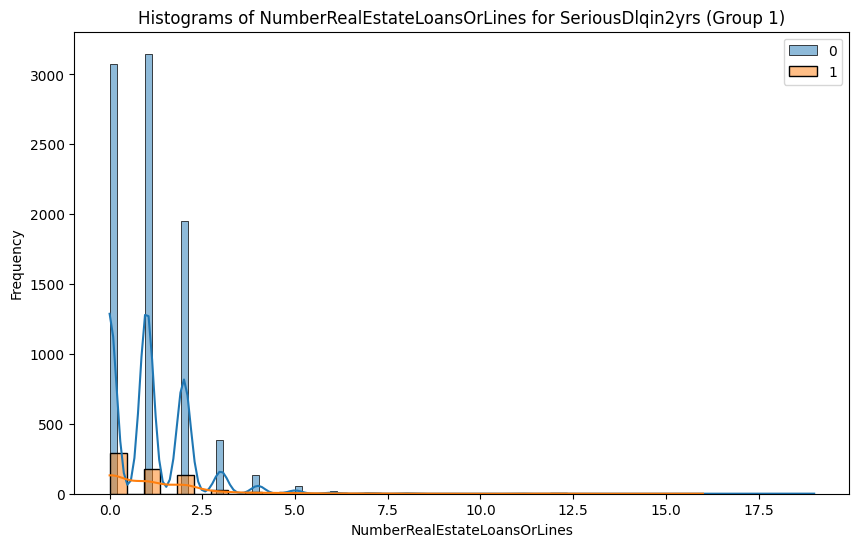

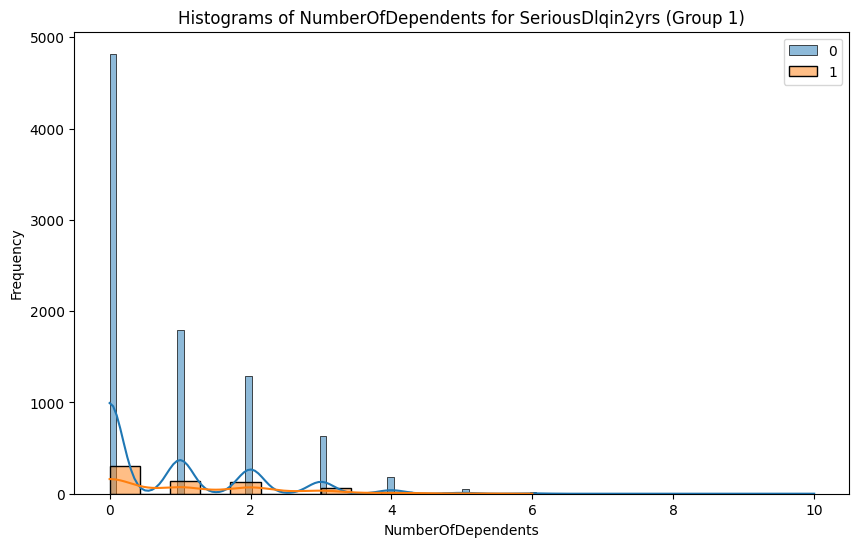

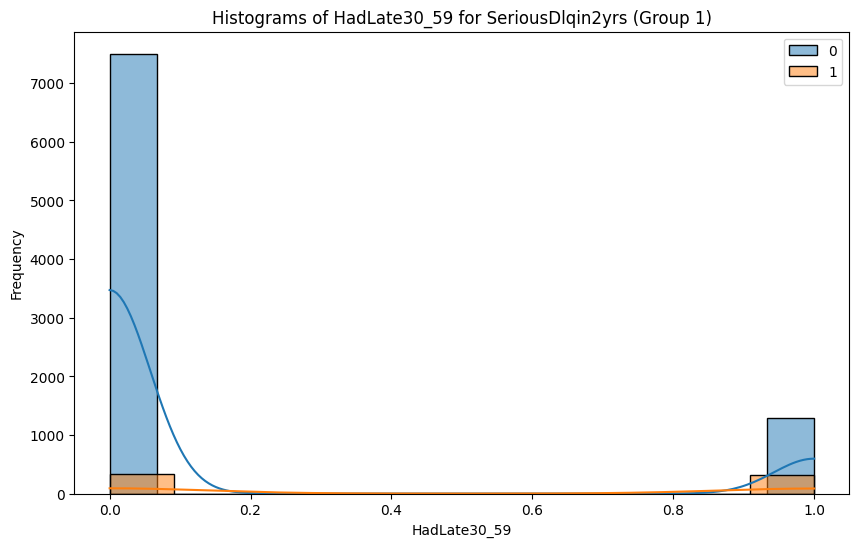

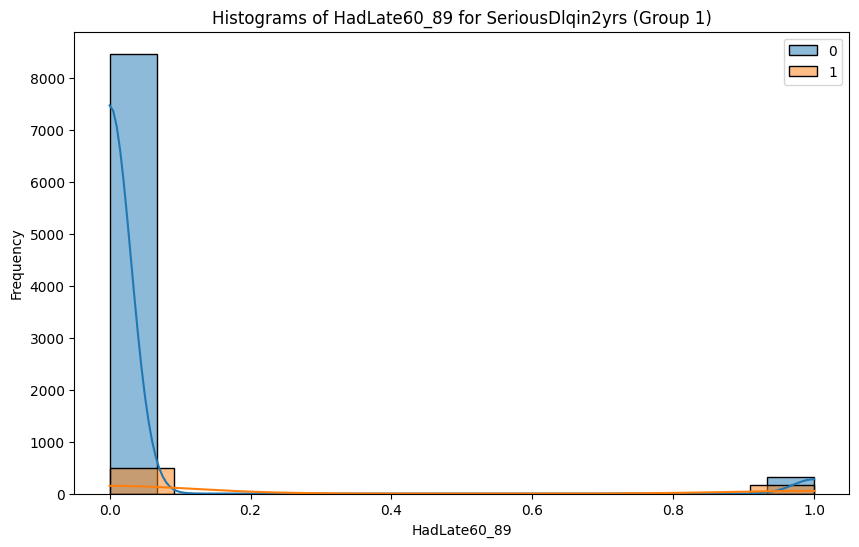

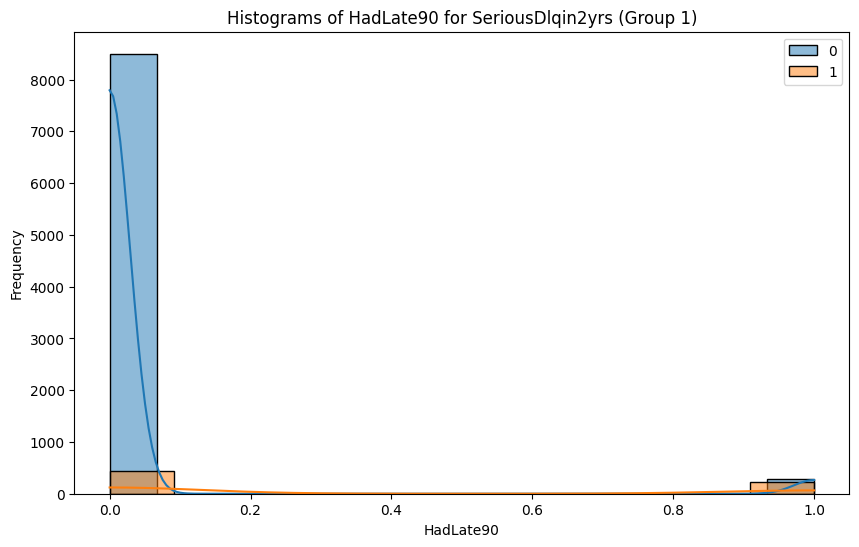

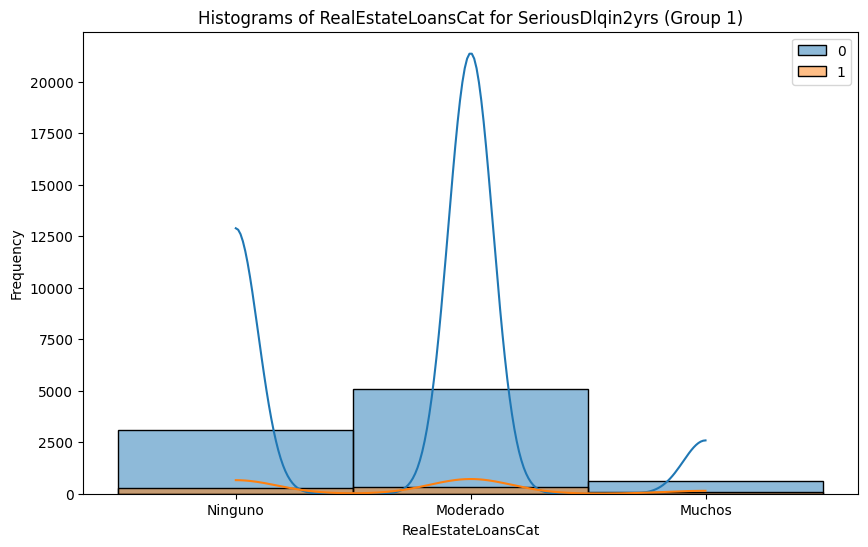

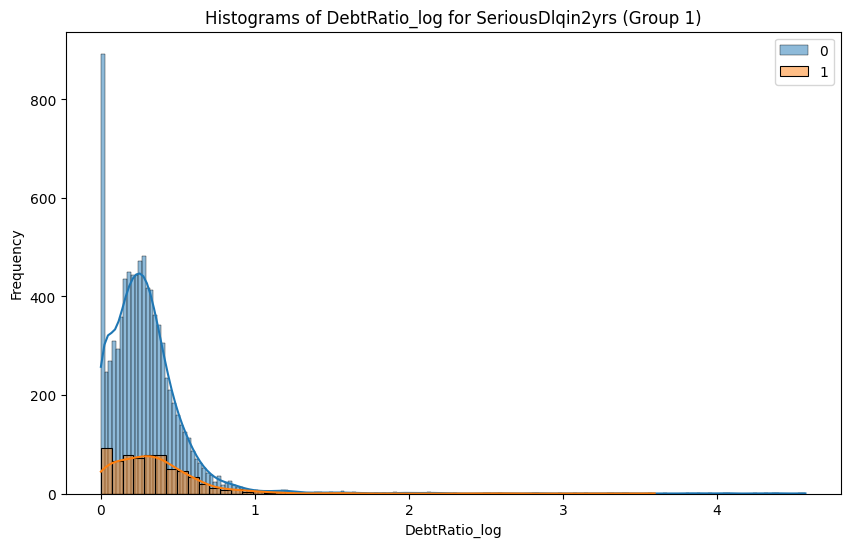

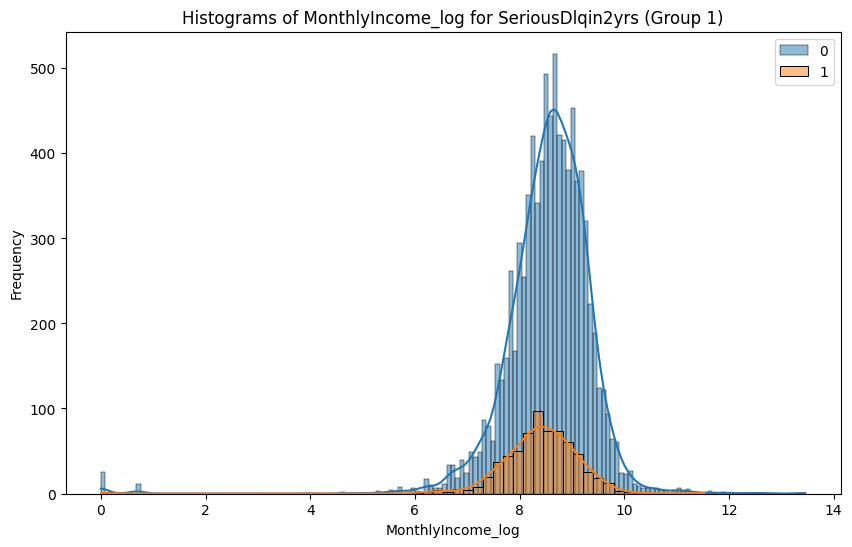

In [96]:
# Asegúrate de tener esta versión consolidada
train_set = X_train.copy()
train_set[target] = y_train

# Excluir el target
features = [col for col in train_set.columns if col != target]

# Lanzar la visualización para cada variable
for col in features:
    bt.plot_grouped_histograms(train_set, cat_col=target, num_col=col, group_size=2)

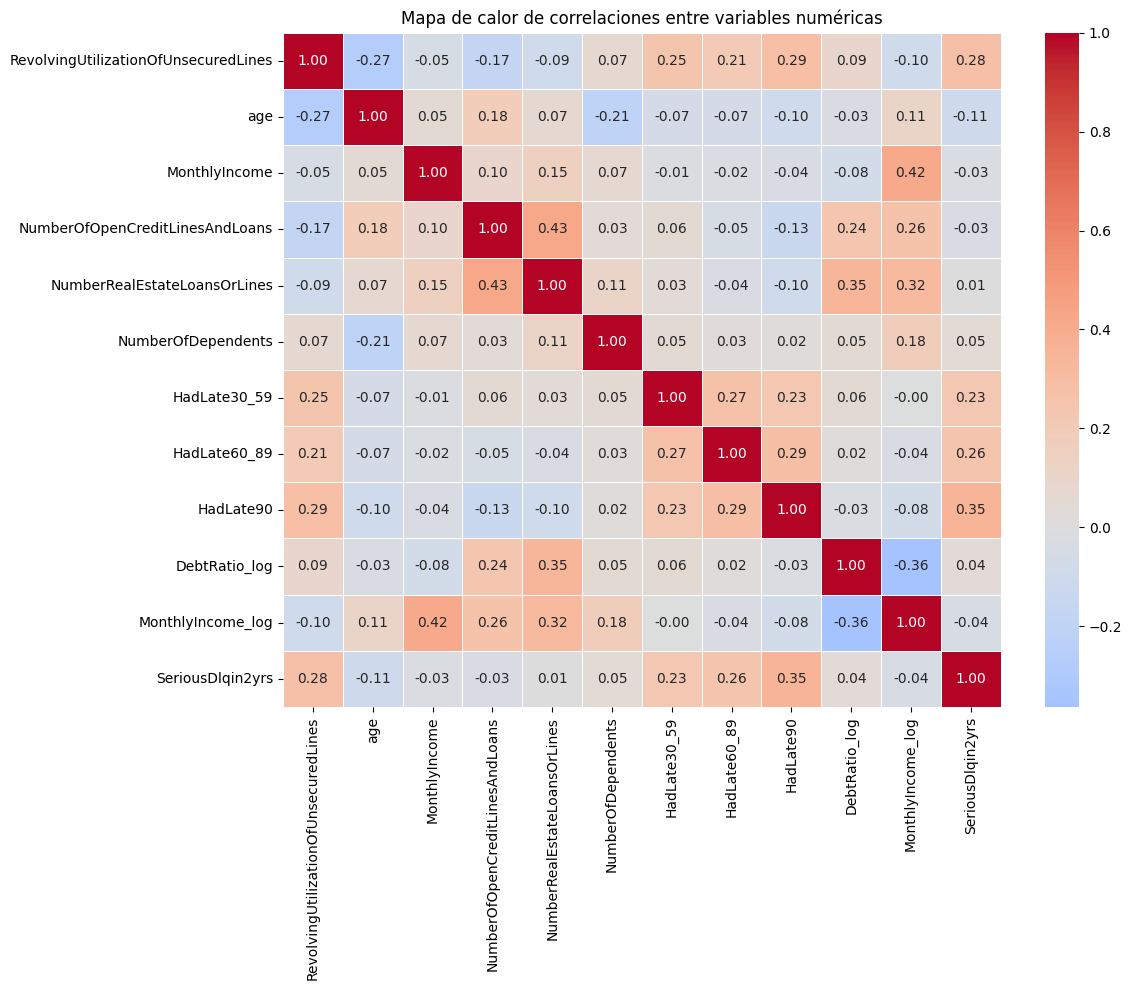

In [97]:
# Unimos X_train con y_train para que incluya el target
heatmap_df = X_train.copy()
heatmap_df["SeriousDlqin2yrs"] = y_train

# Calculamos matriz de correlación de variables numéricas
corr_matrix = heatmap_df.corr(numeric_only=True)

# Visualizamos con sns.heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f")
plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.tight_layout()
plt.show()

Empiezo con la fase visual + correlación + covarianza

In [98]:
eda_df = X_train.copy()
eda_df["SeriousDlqin2yrs"] = y_train

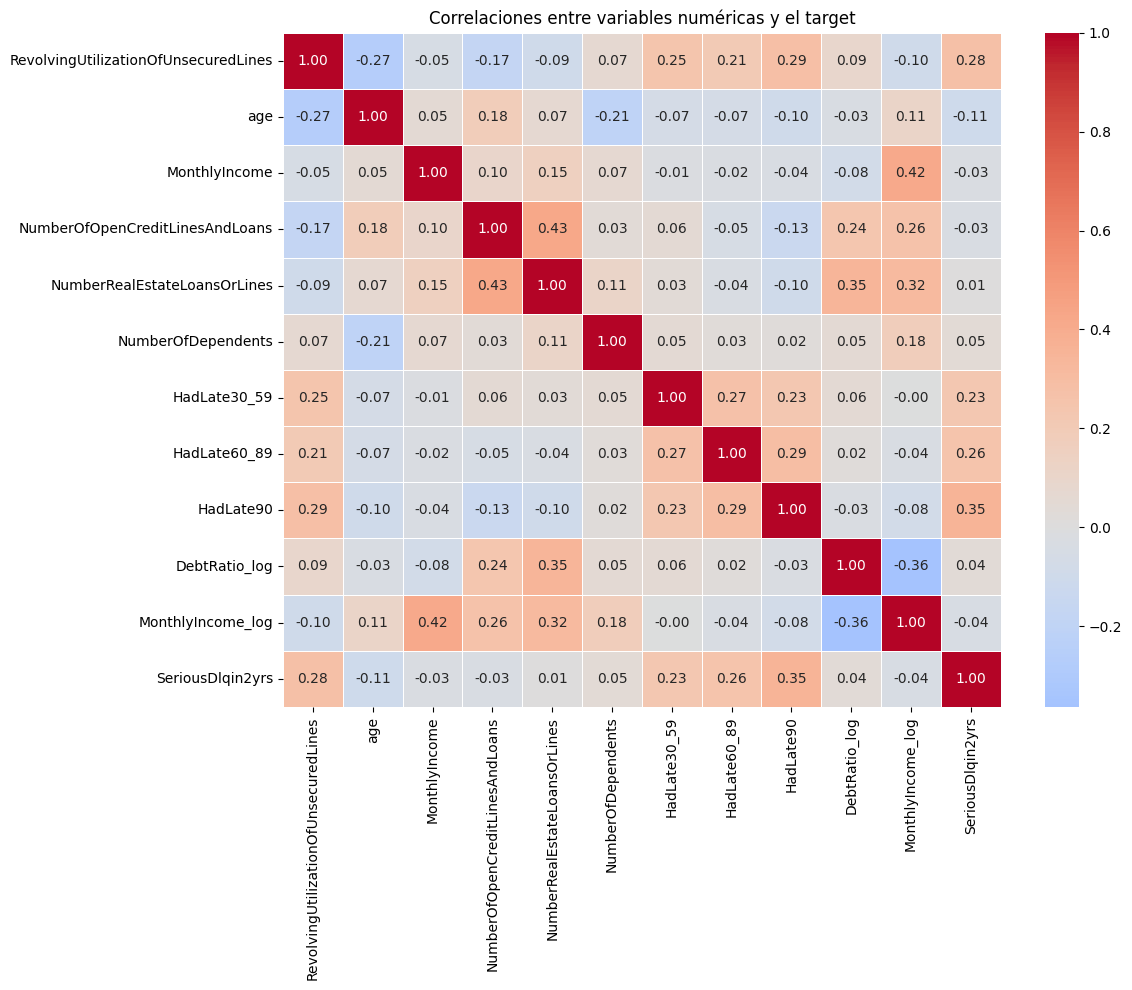

In [99]:
#Heatmap sólo numéricas
plt.figure(figsize=(12,10))
sns.heatmap(
    eda_df.corr(numeric_only=True),
    annot=True, cmap='coolwarm',
    center=0, fmt=".2f",
    linewidths=0.5
)
plt.title("Correlaciones entre variables numéricas y el target")
plt.tight_layout()
plt.show()

Variables más correlacionadas: HadLate90, HadLate60_89, HadLate30_59 y Revolving...  


In [100]:
# Sólo variables numéricas
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# Evaluar varianza
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train[numeric_cols])

# Variables que pasan el filtro
vars_con_varianza = numeric_cols[selector.get_support()].tolist()

# Variables con varianza muy baja
vars_poca_varianza = list(set(numeric_cols) - set(vars_con_varianza))

print("Variables con poca varianza:", vars_poca_varianza)

Variables con poca varianza: []


In [101]:
#Guardo la primera selección de variables basada en análisis visual, correlaciones y filtrado de baja varianza
features_corr_visual = [
    "HadLate90",
    "HadLate60_89",
    "HadLate30_59",
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "DebtRatio_log"  # podríamos debatir este último
]

In [102]:
# 1. Seleccionamos columnas numéricas
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 2. Aplicamos SelectKBest con ANOVA (F-test)
selector_num = SelectKBest(score_func=f_classif, k=6)
selector_num.fit(X_train[num_cols], y_train)

# 3. Obtenemos las puntuaciones ANOVA y las ordenamos en un DataFrame
anova_scores = selector_num.scores_
anova_df = pd.Series(anova_scores, index=num_cols).sort_values(ascending=False)

# 4. Mostramos el ranking
print(" Puntuaciones ANOVA (F-test) por variable numérica:")
print(anova_df)

# 5. Extraemos las mejores (k=6)
selected_num_features = anova_df.head(6).index.tolist()

 Puntuaciones ANOVA (F-test) por variable numérica:
HadLate90                               1345.861997
RevolvingUtilizationOfUnsecuredLines     788.269908
HadLate60_89                             678.343021
HadLate30_59                             542.843886
age                                      105.857431
NumberOfDependents                        20.125285
MonthlyIncome_log                         16.118871
DebtRatio_log                             12.636672
NumberOfOpenCreditLinesAndLoans           10.626153
MonthlyIncome                              6.124270
NumberRealEstateLoansOrLines               0.314679
dtype: float64


In [103]:
# 1. Identificamos columnas categóricas
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# 2. Codificamos ordinalmente para usar MI
X_cat_encoded = X_train[cat_cols].copy()
encoder = OrdinalEncoder()
X_cat_encoded[cat_cols] = encoder.fit_transform(X_cat_encoded)

# 3. Calculamos Mutual Information
mi_scores = mutual_info_classif(X_cat_encoded, y_train, discrete_features=True, random_state=42)

# 4. Creamos Serie ordenada con puntuaciones
mi_series = pd.Series(mi_scores, index=cat_cols).sort_values(ascending=False)

# 5. Mostramos resultados
print("\n Mutual Information por variable categórica:")
print(mi_series)

# 6. Tomamos las más informativas (por ejemplo, 2)
selected_cat_features = mi_series.head(2).index.tolist()


 Mutual Information por variable categórica:
RealEstateLoansCat    0.001573
dtype: float64


In [104]:
features_kbest = selected_num_features + selected_cat_features

print("\n Lista combinada (SelectKBest + MI):")
print(features_kbest)


 Lista combinada (SelectKBest + MI):
['HadLate90', 'RevolvingUtilizationOfUnsecuredLines', 'HadLate60_89', 'HadLate30_59', 'age', 'NumberOfDependents', 'RealEstateLoansCat']


In [105]:
# 1. Copiamos X_train y codificamos variables categóricas si quedan
X_model_input = X_train.copy()

# Identificamos columnas categóricas
cat_cols = X_model_input.select_dtypes(include=["object", "category"]).columns.tolist()

# Usamos codificación ordinal si las hay

if cat_cols:
    encoder = OrdinalEncoder()
    X_model_input[cat_cols] = encoder.fit_transform(X_model_input[cat_cols])

# 2. Entrenamos el modelo con los datos codificados
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_model_input, y_train)

# 3. Aplicamos SelectFromModel

sfm = SelectFromModel(rf_clf, threshold="median", prefit=True)

# 4. Obtenemos las features seleccionadas
selected_features_sfm = X_model_input.columns[sfm.get_support()].tolist()

# 5. Mostramos su importancia ordenada
importances = rf_clf.feature_importances_
importances_df = pd.Series(importances, index=X_model_input.columns).sort_values(ascending=False)

print("Variables seleccionadas por SelectFromModel:")
print(importances_df.loc[selected_features_sfm])

Variables seleccionadas por SelectFromModel:
RevolvingUtilizationOfUnsecuredLines    0.174696
age                                     0.108148
MonthlyIncome                           0.122470
NumberOfOpenCreditLinesAndLoans         0.093228
DebtRatio_log                           0.135826
MonthlyIncome_log                       0.120093
dtype: float64


In [106]:
#guardo mi lista
features_sfm = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "DebtRatio_log",
    "MonthlyIncome_log"
]

In [107]:
#RFE con regresión logística como base


# Asegúrate de tener los datos bien codificados
X_rfe = X_train.copy()

# Convertimos variables categóricas (si hay) a ordinales

cat_cols = X_rfe.select_dtypes(include=["object", "category"]).columns.tolist()

if cat_cols:
    encoder = OrdinalEncoder()
    X_rfe[cat_cols] = encoder.fit_transform(X_rfe[cat_cols])

# Definimos modelo base (simple, sin regularización fuerte)
lr = LogisticRegression(solver='liblinear', random_state=42)

# RFE: pedimos las 6 mejores variables
rfe = RFE(estimator=lr, n_features_to_select=6)
rfe.fit(X_rfe, y_train)

# Extraemos las seleccionadas
features_rfe = X_rfe.columns[rfe.get_support()].tolist()

# Mostramos resultado
print("Variables seleccionadas por RFE:")
print(features_rfe)

Variables seleccionadas por RFE:
['RevolvingUtilizationOfUnsecuredLines', 'NumberRealEstateLoansOrLines', 'HadLate30_59', 'HadLate60_89', 'HadLate90', 'MonthlyIncome_log']


In [108]:
features_rfe = [
    "RevolvingUtilizationOfUnsecuredLines",
    "NumberRealEstateLoansOrLines",
    "HadLate30_59",
    "HadLate60_89",
    "HadLate90",
    "MonthlyIncome_log"
]

In [109]:
# Preparamos X_train: codificamos categóricas si quedan
X_sfs = X_train.copy()
cat_cols = X_sfs.select_dtypes(include=["object", "category"]).columns.tolist()

if cat_cols:
    encoder = OrdinalEncoder()
    X_sfs[cat_cols] = encoder.fit_transform(X_sfs[cat_cols])

# Modelo base
lr_model = LogisticRegression(solver='liblinear', random_state=42)

# Selección secuencial hacia adelante con 6 features
sfs = SequentialFeatureSelector(
    lr_model,
    n_features_to_select=6,
    direction='forward',
    scoring='recall',
    cv=5,
    n_jobs=-1
)

# Aplicamos SFS
sfs.fit(X_sfs, y_train)

# Obtenemos las variables seleccionadas
features_sfs = X_sfs.columns[sfs.get_support()].tolist()

# Mostramos resultado
print("Variables seleccionadas con SFS:")
print(features_sfs)

Variables seleccionadas con SFS:
['RevolvingUtilizationOfUnsecuredLines', 'NumberRealEstateLoansOrLines', 'HadLate90', 'RealEstateLoansCat', 'DebtRatio_log', 'MonthlyIncome_log']


In [110]:
features_sfs = [
    "RevolvingUtilizationOfUnsecuredLines",
    "NumberRealEstateLoansOrLines",
    "HadLate90",
    "RealEstateLoansCat",
    "DebtRatio_log",
    "MonthlyIncome_log"
]

In [111]:
#HardVoting para quedarme con las más votadas

listas_de_features = [
    features_corr_visual,   # 1: Análisis visual + correlación
    features_kbest,         # 2: SelectKBest + MI
    features_sfm,           # 3: SelectFromModel
    features_rfe,           # 4: RFE
    features_sfs            # 5: SFS
]


# Unimos todas las variables en una sola lista
todas_las_vars = [var for lista in listas_de_features for var in lista]

# Contamos ocurrencias
conteo = Counter(todas_las_vars)

# Lo mostramos en orden de mayor a menor votos
conteo_df = pd.DataFrame.from_dict(conteo, orient='index', columns=["Votos"]).sort_values(by="Votos", ascending=False)

print("Recuento de votos por variable:")
print(conteo_df)

Recuento de votos por variable:
                                      Votos
RevolvingUtilizationOfUnsecuredLines      5
HadLate90                                 4
HadLate60_89                              3
HadLate30_59                              3
age                                       3
DebtRatio_log                             3
MonthlyIncome_log                         3
RealEstateLoansCat                        2
NumberRealEstateLoansOrLines              2
NumberOfDependents                        1
NumberOfOpenCreditLinesAndLoans           1
MonthlyIncome                             1


In [112]:
features_hard_vote = conteo_df.head(6).index.tolist()

print("\nLista final (votación dura entre métodos):")
print(features_hard_vote)


Lista final (votación dura entre métodos):
['RevolvingUtilizationOfUnsecuredLines', 'HadLate90', 'HadLate60_89', 'HadLate30_59', 'age', 'DebtRatio_log']


In [113]:
features_hard_vote = [
    "RevolvingUtilizationOfUnsecuredLines",
    "HadLate90",
    "HadLate60_89",
    "HadLate30_59",
    "age",
    "DebtRatio_log"
]

Modelos

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [115]:
#Tengo 6 listas identificadas
feature_sets = {
    "corr_visual": features_corr_visual,
    "kbest": features_kbest,
    "sfm": features_sfm,
    "rfe": features_rfe,
    "sfs": features_sfs,
    "hard_vote": features_hard_vote
}

In [116]:
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)

# Diccionario de modelos
modelos = {
    "LogReg": LogisticRegression(solver='liblinear', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb_model
}

# Asegúrate de tener tus listas nombradas correctamente
feature_sets = {
    "corr_visual": features_corr_visual,
    "kbest": features_kbest,
    "sfm": features_sfm,
    "rfe": features_rfe,
    "sfs": features_sfs,
    "hard_vote": features_hard_vote
}

# Lista para resultados
resultados = []

# Recorremos cada combinación modelo + conjunto de features
for nombre_modelo, modelo in modelos.items():
    for nombre_lista, lista_vars in feature_sets.items():
        X_subset = X_train[lista_vars].copy()

        # Codificamos si hay categóricas
        cat_cols = X_subset.select_dtypes(include=["object", "category"]).columns.tolist()
        if cat_cols:
            encoder = OrdinalEncoder()
            X_subset[cat_cols] = encoder.fit_transform(X_subset[cat_cols])

        # Validación cruzada con recall
        scores = cross_val_score(
            modelo,
            X_subset,
            y_train,
            cv=5,
            scoring="recall"
        )

        resultados.append({
            "Modelo": nombre_modelo,
            "Feature_Set": nombre_lista,
            "Recall_Medio": scores.mean()
        })

# Mostramos los resultados
df_resultados = pd.DataFrame(resultados).sort_values(by="Recall_Medio", ascending=False)

print("Resultados de validación cruzada (recall promedio):")
print(df_resultados)

Resultados de validación cruzada (recall promedio):
          Modelo  Feature_Set  Recall_Medio
15       XGBoost          rfe      0.225871
9   RandomForest          rfe      0.215379
4         LogReg          sfs      0.212417
12       XGBoost  corr_visual      0.204773
17       XGBoost    hard_vote      0.204773
16       XGBoost          sfs      0.197277
11  RandomForest    hard_vote      0.194293
13       XGBoost        kbest      0.194281
3         LogReg          rfe      0.188278
6   RandomForest  corr_visual      0.188243
1         LogReg        kbest      0.186774
10  RandomForest          sfs      0.180736
0         LogReg  corr_visual      0.179255
5         LogReg    hard_vote      0.179255
7   RandomForest        kbest      0.174687
14       XGBoost          sfm      0.088824
8   RandomForest          sfm      0.060253
2         LogReg          sfm      0.006026


Combinación ganadora: XGBoost con lista de RFE y recall promedio de 0.2259

Repasamos las variables RFE

In [117]:
features_rfe = [
    "RevolvingUtilizationOfUnsecuredLines",  # potencia altísima: aparece en casi todos los métodos
    "NumberRealEstateLoansOrLines",          # nuevo aquí, relevante junto a RealEstateLoansCat
    "HadLate30_59",                          # impagos recientes: impacto directo en el target
    "HadLate60_89",                          # impagos moderadamente antiguos
    "HadLate90",                             # impagos graves → muy correlacionado con morosidad
    "MonthlyIncome_log"                      # la versión transformada del ingreso = mejor distribución
]

In [118]:
#Optimización:


# 1. Codificamos X_train con las features RFE
X_grid = X_train[features_rfe].copy()
cat_cols = X_grid.select_dtypes(include=["object", "category"]).columns.tolist()

if cat_cols:
    encoder = OrdinalEncoder()
    X_grid[cat_cols] = encoder.fit_transform(X_grid[cat_cols])

# 2. Definimos el clasificador base
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)

# 3. Definimos la grid
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

# 4. GridSearch con validación cruzada
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 5. Entrenamos
grid.fit(X_grid, y_train)

# 6. Mostramos los mejores resultados
print("\nMejor combinación de hiperparámetros:")
print(grid.best_params_)
print(f"Recall medio (CV): {grid.best_score_:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Mejor combinación de hiperparámetros:
{'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Recall medio (CV): 0.2290


Evaluamos test

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9416    0.9823    0.9615      2198
           1     0.4507    0.1928    0.2700       166

    accuracy                         0.9268      2364
   macro avg     0.6961    0.5875    0.6158      2364
weighted avg     0.9071    0.9268    0.9129      2364

Matriz de confusión:
[[2159   39]
 [ 134   32]]
AUC-ROC: 0.8178


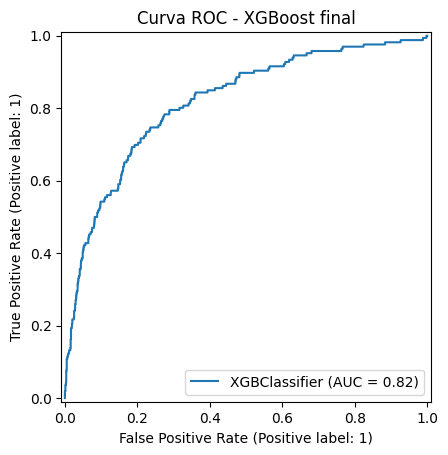

In [119]:
# 1. Preparamos los datos de test
X_test_eval = X_test[features_rfe].copy()

# Codificamos categóricas si es necesario
cat_cols = X_test_eval.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    encoder = OrdinalEncoder()
    X_test_eval[cat_cols] = encoder.fit_transform(X_test_eval[cat_cols])

# 2. Entrenamos modelo final con los mejores hiperparámetros
final_xgb = XGBClassifier(
    colsample_bytree=1,
    learning_rate=0.2,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)
final_xgb.fit(X_train[features_rfe], y_train)

# 3. Predicciones
y_pred = final_xgb.predict(X_test_eval)
y_proba = final_xgb.predict_proba(X_test_eval)[:, 1]

# 4. Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# 5. Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# 6. AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

# 7. Curva ROC
RocCurveDisplay.from_estimator(final_xgb, X_test_eval, y_test)
plt.title("Curva ROC - XGBoost final")
plt.show()

Precisión clase 1 (morosos): 0.45 cucando predice impago acierta casi la mitard de las veces.  
Recall clase 1: 0.19 identifica el 19% de los morosos reales.
F1-score clase 1: 0.27 equilibrio algo modesto pero recordamos un target muy desbalanceado.
Accuracy: 92.7% pero este valor no es útil porque está desbalanceado.
AUC-ROC: 0.82 buena capacidad de discriminación del modelo.

El modelo acierta muy bien con los no morosos pero deja escapar bastantes morosos. Lo que sí predice como impago es razonablemente fiable.

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.